![](https://i.imgur.com/KXtGwDB.jpg)

**THIS IS MY FIRST PYTHON KERNEL (on Kaggle) AND A WORK IN PROGRESS (31/05/19)**

To whom it may concern,

I'm currently looking for full-time work in North America, Europe, or Remote. If you or someone you know is hiring for the type of work displayed in this kernel I'd be interested in speaking with you. All of my past work experience is in digital marketing but I have >1000hrs building full-stack ReactJS apps in NodeJS and a handfull of kernels / notebooks I can share that display knowledge of Computer Vision, Natural Language Processing, Sequence Mining, Advanced Visualization & other data science-type stuff written in R & Python.

I can be reached at: Eric@Casey(dot)Works

**The Problem:**

We have 5,310 pairs of single photos that we have to submit probabilities of being related to eachother between 0-1. With 0 being not related at all to 1 being related.

**The Data:**

We have been given a training dataset of 3,598 pairs of individuals who ARE related to eachother and part of one of 470 families in the dataset. Each of these individuals has at least one photo.

I've decided to add another kaggle-hosted dataset with 381 other people to use to balance the pairs that are related to some that are unrelated to anyone in the training dataset. Also to make this more wild.

**Feature Statuses:**

* [WORKING] - Age Detection 1 - https://github.com/spmallick/learnopencv
* [WORKING] - Gender Detection 1 - https://github.com/spmallick/learnopencv
* [WORKING] - FaceNet - https://arxiv.org/abs/1503.03832
* [WORKING] - B&W Image SSIM - https://en.wikipedia.org/wiki/Structural_similarity
* [WORKING] - Oxford Visual Geometry Group - http://www.robots.ox.ac.uk/~vgg/data/vgg_face/
* [ NEXT ] - Selecting Optimal Comparison Photos (finding frontal pose)
* [ NEXT ] - Generating Family / Descendance Clusters Somehow

**Dataset Notes:**

* Mix of photos with different genders, makeup, ages & headwear. 
* Some are photos B&W, some are color, different image qualities as well.
* They also have different head poses, expressions & lighting. (but the 3rd-party dataset appears to have just a green background)

**Model Notes:**

* Using two different pre-trained facial verification / recognition models doesn't help here (and just takes way longer).

**TODOS:**

- Face angle detection, for getting aligned images? just use image symmetry? align nose points to center of img?
- Eye color?
- Hair color?
- Aligning age? What's the age distributions of the list of photos for each individual?
- Ethnicity detection?
- Delaunay triangulation of each family? Then clustering?
- Expression detection?
- Average RGB in image?
- Landmarks? (doesn't seem to help much in other public kernels)

**Links:**

- https://github.com/wondonghyeon/face-classification
- http://www.tomgibara.com/computer-vision/symmetry-detection-algorithm
- https://github.com/usc-sail/mica-race-from-face
- https://en.wikipedia.org/wiki/Delaunay_triangulation
- http://www.robots.ox.ac.uk/~vgg/data/vgg_face/
- https://github.com/AaronJackson/vrn
- https://sefiks.com/2018/08/06/deep-face-recognition-with-keras/
- http://vis-www.cs.umass.edu/lfw/
- https://github.com/rcmalli/keras-vggface
- https://sefiks.com/2019/02/13/apparent-age-and-gender-prediction-in-keras/


** [0] IMPORTS**

In [1]:
!pip install dlib
!pip install git+https://github.com/rcmalli/keras-vggface.git
!pip install imutils

You are using pip version 19.0.3, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
  Cloning https://github.com/rcmalli/keras-vggface.git to /tmp/pip-req-build-jo97_o_l
  Stored in directory: /tmp/pip-ephem-wheel-cache-4l76hzj1/wheels/36/07/46/06c25ce8e9cd396dabe151ea1d8a2bc28dafcb11321c1f3a6d
Successfully built keras-vggface
You are using pip version 19.0.3, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
  Stored in directory: /tmp/.cache/pip/wheels/b2/40/59/139d450e68847ef2f27d876d527b13389dac23df0f66526b5d
Successfully built imutils
You are using pip version 19.0.3, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import os
import sys 
import cv2
import glob
import dlib
import math
import random
import sklearn
import imutils
import imageio
import itertools
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from random import choice, sample
from cv2 import imread
from tqdm import tqdm
from pathlib import Path
from imutils import face_utils
from PIL import Image

from IPython.display import HTML, display
from matplotlib.pyplot import imshow

from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
from scipy.spatial import distance

import keras_vggface
from keras_vggface.vggface import VGGFace       
from keras_applications.imagenet_utils import _obtain_input_shape
from collections import defaultdict
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.layers import Input, Dense, GlobalMaxPool2D, GlobalAvgPool2D, Concatenate, Multiply, Dropout, Subtract, Convolution2D, ZeroPadding2D, MaxPooling2D, Flatten, Activation
from keras.models import Model, Sequential, model_from_json, load_model
from keras.optimizers import Adam
from keras_vggface.utils import preprocess_input
from keras_vggface.vggface import VGGFace
from keras.preprocessing.image import load_img, save_img, img_to_array
from keras.applications.imagenet_utils import preprocess_input
from keras.preprocessing import image

from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from skimage.measure import compare_ssim
from sklearn.decomposition import PCA                    
from skimage.transform import resize          
from sklearn.model_selection import train_test_split     

import xgboost as xgb

print(sys.executable)
# print(os.sys.path)
print(os.listdir("../input"))

Using TensorFlow backend.


/opt/conda/bin/python
['utilities', 'faces-data-new', 'recognizing-faces-in-the-wild', 'facenetkeras', 'vgg-face-weights', 'learnopencvcom-model-weights']


In [3]:
# TODO: Version Check
# TODO: Table of Contents

**[1] PRE-TRAINED COMPUTER VISION MODELS**

In [4]:
# VGG Face
model = Sequential()
model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(Convolution2D(4096, (7, 7), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(4096, (1, 1), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(2622, (1, 1)))
model.add(Flatten())
model.add(Activation('softmax'))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [5]:
# Age Detection - https://github.com/spmallick/learnopencv
ageProto = "../input/learnopencvcom-model-weights/age_deploy.prototxt"
ageModel = "../input/learnopencvcom-model-weights/age_net.caffemodel"

# Gender Detection - https://github.com/spmallick/learnopencv
genderProto = "../input/learnopencvcom-model-weights/gender_deploy.prototxt"
genderModel = "../input/learnopencvcom-model-weights/gender_net.caffemodel"

# FaceNet - https://arxiv.org/abs/1503.03832
facenet_model = '../input/facenetkeras/facenet_keras_1.h5'
facenetModel = load_model(facenet_model)

# VGG - http://www.robots.ox.ac.uk/~vgg/data/vgg_face/
model.load_weights('../input/vgg-face-weights/vgg_face_weights.h5')
vgg_face_descriptor = Model(inputs=model.layers[0].input, outputs=model.layers[-2].output)

# 68 Landmarks - https://github.com/spmallick/learnopencv
predictor_path_68 = '../input/utilities/shape_predictor_68_face_landmarks.dat'

/opt/conda/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


**[3] IMPORTING THE TRAIN & TEST DATA**

In [6]:
# TEST & TRAIN FILES
train_df = pd.read_csv('../input/recognizing-faces-in-the-wild/train_relationships.csv')
test_df = pd.read_csv('../input/recognizing-faces-in-the-wild/sample_submission.csv')

# BASE PATHS FOR IMAGES
train_img_path = Path('../input/recognizing-faces-in-the-wild/train/')
test_img_path = Path('../input/recognizing-faces-in-the-wild/test/')

**[4] DATASET INSPECTION**

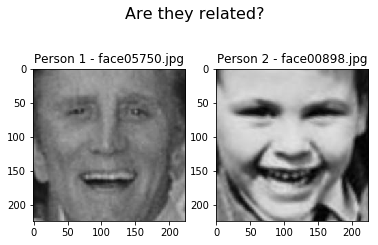

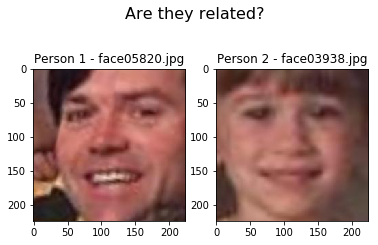

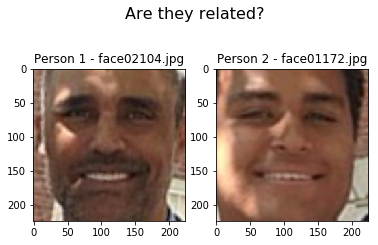

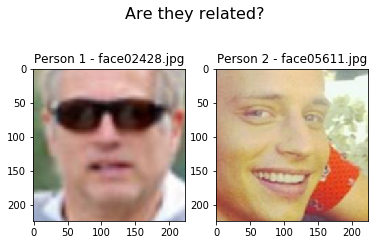

In [7]:
def inspect_pair(index):

    img_1 = mpimg.imread( test_img_path / test_df.loc[index, 'img_pair'].split('-')[0] )
    img_2 = mpimg.imread( test_img_path / test_df.loc[index, 'img_pair'].split('-')[1] )

    fig = plt.figure()
    fig.suptitle('Are they related?', fontsize=16)
    a = fig.add_subplot(1, 2, 1)
    imgplot = plt.imshow(img_1)
    a.set_title('Person 1 - ' + test_df.loc[index, 'img_pair'].split('-')[0])
    a = fig.add_subplot(1, 2, 2)
    imgplot = plt.imshow(img_2)
    imgplot.set_clim(0.0, 0.7)
    a.set_title('Person 2 - ' + test_df.loc[index, 'img_pair'].split('-')[1])
    
inspect_pair(1) 
inspect_pair(2) # Celebrities.
inspect_pair(3) # Same Background, probably related.  1
inspect_pair(4) 

## TODO: Make this 2x2

In [8]:
# def inspect_individual(index):
#     # loop through all photos of that individual in the training data
#     print(index)
#     print(train_img_path)
#     print(train_df.loc[index, 'p1'])
    
#     img_list = os.listdir(train_img_path / train_df.loc[index, 'p1'])
    
#     print("this individual has ", len(img_list), " photos")
    
#     for img in img_list:
#         print(img)
#         img = mpimg.imread( train_img_path / train_df.loc[index, 'p1'] / img )
#         plt.imshow(img)

# inspect_individual(1)

In [9]:
# def inspect_family(id):
#     print('Family ID: ', id)
#     print('Family Members: ')
    
# inspect_family('F0')

In [10]:
def get_profile(individual):
    if len(individual.split('/')) == 2: # ORIGINAL DATASET
        if len(train_df[train_df['p1'] == individual]['p1_photo_count'].head(1).values) == 0:
            return {
                'photo_list': train_df[train_df['p2'] == individual]['p2_photo_list'].head(1).values[0],
                'photo_count': train_df[train_df['p2'] == individual]['p2_photo_count'].head(1).values[0]
            }
        else:
            return {                                                        # it's not stupid if it works
                'photo_list': train_df[train_df['p1'] == individual]['p1_photo_list'].head(1).values[0],
                'photo_count': train_df[train_df['p1'] == individual]['p1_photo_count'].head(1).values[0]
            }
    else:                              # 3RD PARTY DATASET
        return {
            'photo_list': third_party[third_party['p1'] == individual]['p1_photo_list'].head(1).values[0],
            'photo_count': third_party[third_party['p1'] == individual]['p1_photo_count'].head(1).values[0]
        }

**[5] REFORMATTING TRAINING DATASET**

In [11]:
# SETUP SOME COLUMNS TO USE LATER
train_df['is_related'] = 1
train_df['p1_photo_count'] = 0
train_df['p2_photo_count'] = 0
train_df['p1_photo_list'] = ''
train_df['p2_photo_list'] = ''
train_df['combo'] = ''

print(train_df.shape[0], ' rows of confirmed kinship for model training')

# LOOP THROUGH EACH KNOWN KINSHIP
for i in range(0, train_df.shape[0]) :
    p1_path = '../input/recognizing-faces-in-the-wild/train/' + train_df.loc[i, 'p1'] + "/"
    p2_path = '../input/recognizing-faces-in-the-wild/train/' + train_df.loc[i, 'p2'] + "/"

    # CHECK IF DIRECTORY EXISTS (sometimes it's not present, unless I've done something wrong)
    if os.path.isdir(p1_path) & os.path.isdir(p2_path):
        train_df.loc[i, 'p1_photo_count'] = len(os.listdir(train_img_path / train_df.loc[i, 'p1'] ))
        train_df.loc[i, 'p2_photo_count'] = len(os.listdir(train_img_path / train_df.loc[i, 'p2'] ))
        train_df.at[i, 'p1_photo_list'] = os.listdir(train_img_path / train_df.loc[i, 'p1'] )
        train_df.at[i, 'p2_photo_list'] = os.listdir(train_img_path / train_df.loc[i, 'p2'] )
        train_df.loc[i, 'combo'] = train_df.loc[i, 'p1'] + '-' + train_df.loc[i, 'p2']

train_columns = list(train_df.columns.values)

3598  rows of confirmed kinship for model training


In [12]:
train_df.head(5)

,p1,p2,is_related,p1_photo_count,p2_photo_count,p1_photo_list,p2_photo_list,combo
0,F0002/MID1,F0002/MID3,1,10,8,"[P00009_face3.jpg, P00013_face2.jpg, P00010_fa...","[P00009_face1.jpg, P00018_face2.jpg, P00017_fa...",F0002/MID1-F0002/MID3
1,F0002/MID2,F0002/MID3,1,9,8,"[P00017_face2.jpg, P00010_face3.jpg, P00013_fa...","[P00009_face1.jpg, P00018_face2.jpg, P00017_fa...",F0002/MID2-F0002/MID3
2,F0005/MID1,F0005/MID2,1,9,8,"[P00056_face1.jpg, P00058_face2.jpg, P00053_fa...","[P00054_face2.jpg, P00061_face2.jpg, P00053_fa...",F0005/MID1-F0005/MID2
3,F0005/MID3,F0005/MID2,1,6,8,"[P00061_face1.jpg, P00059_face1.jpg, P00062_fa...","[P00054_face2.jpg, P00061_face2.jpg, P00053_fa...",F0005/MID3-F0005/MID2
4,F0009/MID1,F0009/MID4,1,41,20,"[P11714_face1.jpg, P11750_face1.jpg, P10571_fa...","[P11723_face1.jpg, P11757_face1.jpg, P11754_fa...",F0009/MID1-F0009/MID4


**[6] ADD 3RD PARTY DATASET TO MAKE THIS *MORE WILD***

In [13]:
new_data = {}
individual_list = []
third_party = pd.DataFrame(columns = train_columns)

img_list_3rd = os.listdir('../input/faces-data-new/images/images')

print(len(img_list_3rd), ' photos in the given dataset')

for i in range(0, len(img_list_3rd)):
    if img_list_3rd[i].split('.')[0] not in individual_list:
        individual_list.append(img_list_3rd[i].split('.')[0]) 
        new_data[img_list_3rd[i].split('.')[0]] = { 
            'photo_count': 1, 
            'photo_list': [ img_list_3rd[i] ] 
        }
    else:
        files = new_data[img_list_3rd[i].split('.')[0]]['photo_list']
        files.append(img_list_3rd[i])
        new_data[img_list_3rd[i].split('.')[0]] = { 
            'photo_count': new_data[img_list_3rd[i].split('.')[0]]['photo_count'] + 1, 
            'photo_list': files
        }

print(len(individual_list), ' individuals from 3rd party sources to be added')

for i in range(0, len(individual_list)):
    third_party.loc[i, 'p1'] = individual_list[i]
    third_party.loc[i, 'is_related'] = 0
    third_party.loc[i, 'p1_photo_count'] = new_data[individual_list[i]]['photo_count']
    third_party.loc[i, 'p1_photo_list'] = new_data[individual_list[i]]['photo_list']
        
# print(third_party.shape)

7864  photos in the given dataset
391  individuals from 3rd party sources to be added


**[7] GENERATING ALL POSSIBLE COMBINATIONS OF INDIVIDUALS**

In [14]:
# GET A LIST OF ALL INDIVIDUALS IN THE TRAINING DATA
train_individuals = list(set(list(train_df['p1']) + list(train_df['p2'])))
print(len(train_individuals), ' individuals in training dataset')
print(len(individual_list), ' individuals from the 3rd party data')
all_individuals = train_individuals + individual_list
print(len(all_individuals), ' total individuals in the new training data')

# GENERATE ALL POSSIBLE COMBINATIONS OF INDIVIDUALS
combinations = list(itertools.combinations(train_individuals + individual_list, 2))
print(len(combinations), ' possible 2-way combinations of individuals')

# CLEAR OUT ANY RELATED COMBINATIONS
for i in tqdm(range(0, train_df.shape[0])):
    combo = ( train_df.loc[i, 'p1'], train_df.loc[i, 'p2'] )
    if combo in combinations:
        combinations.remove(combo)
print(len(combinations), ' possible 2-way combinations of individuals after removing duplicates/related people')

  0%|          | 2/3598 [00:00<06:52,  8.71it/s]

2412  individuals in training dataset
391  individuals from the 3rd party data
2803  total individuals in the new training data
3927003  possible 2-way combinations of individuals


100%|██████████| 3598/3598 [06:08<00:00,  8.42it/s]

3925199  possible 2-way combinations of individuals after removing duplicates/related people


**[8] GENERATING NEW UNRELATED ROWS FOR TRAINING DATASET**

In [15]:
goal_n = 10000  # 10k this gives us a 64/36-ish ratio for our target of 'is_related'

print(goal_n - train_df.shape[0], ' new rows to be created for training dataset')

# generating a list of random numbers for indexes to grab from the combinations list
random_list = []
for i in range(0, goal_n - train_df.shape[0]): # for each of the number of rows I need to add
    x = random.randint(0, len(combinations))   # generate a random number between 0 and combinations length
    random_list.append(x)

rows_list = []

for i in range(0, goal_n - train_df.shape[0]):

    combo = combinations[random_list[i]][0] + '-' + combinations[random_list[i]][1]
    
    p1 = get_profile(combo.split('-')[0])
    p2 = get_profile(combo.split('-')[1])

    new_row = {
        'p1': combinations[random_list[i]][0],
        'p2': combinations[random_list[i]][1],
        'is_related': 0, 
        'p1_photo_count': p1['photo_count'], 
        'p2_photo_count': p2['photo_count'], 
        'p1_photo_list': p1['photo_list'], 
        'p2_photo_list': p2['photo_list'],  
        'combo': combo
    }
    
    rows_list.append(new_row)

new_rows = pd.DataFrame(rows_list)

6402  new rows to be created for training dataset


**[9] MASH RELATED AND UNRELATED TOGETHER**

In [16]:
if train_df.shape[0] <= goal_n:
    train_df = pd.concat( [ train_df, new_rows ], ignore_index=True )

print(train_df.shape[0],' rows after generating new, unrelated pairs of people')
print('the sum of the is_related column is: ', sum(list(train_df['is_related'])))
print('target ratio is: ', sum(list(train_df['is_related'])) /  train_df.shape[0])

train_df = train_df[train_df.p1_photo_count != 0]
train_df = train_df[train_df.p2_photo_count != 0]
train_df = train_df.sample(frac = 1).reset_index(drop = True) # random sort training data (easier to debug)

train_df.head(5)

10000  rows after generating new, unrelated pairs of people
the sum of the is_related column is:  3598
target ratio is:  0.3598


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


,combo,is_related,p1,p1_photo_count,p1_photo_list,p2,p2_photo_count,p2_photo_list
0,F0249/MID6-F0561/MID4,0,F0249/MID6,1,[P02638_face2.jpg],F0561/MID4,4,"[P05895_face5.jpg, P11794_face1.jpg, P11795_fa..."
1,F0425/MID5-F0425/MID9,1,F0425/MID5,2,"[P11467_face1.jpg, P11469_face3.jpg]",F0425/MID9,2,"[P11471_face1.jpg, P11485_face1.jpg]"
2,F0825/MID1-F0825/MID2,1,F0825/MID1,9,"[P08728_face1.jpg, P08729_face3.jpg, P08726_fa...",F0825/MID2,3,"[P08721_face5.jpg, P08722_face1.jpg, P08723_fa..."
3,F0831/MID4-F0831/MID6,1,F0831/MID4,5,"[P08785_face1.jpg, P08789_face3.jpg, P08782_fa...",F0831/MID6,1,[P08784_face1.jpg]
4,F0101/MID7-9540784,0,F0101/MID7,1,[P01045_face2.jpg],9540784,20,"[9540784.18.jpg, 9540784.20.jpg, 9540784.1.jpg..."


**[10] FEATURE CREATION FUNCTIONS**

In [17]:
def get_age(path):
    # https://github.com/spmallick/learnopencv
    # This returns the index of the age bucket based on a pre-trained model by Satya Mallick
    
    cv_face = cv2.imread(path, cv2.COLOR_BGR2GRAY)
    ageNet = cv2.dnn.readNet(ageModel, ageProto)
    MODEL_MEAN_VALUES = (78.4263377603, 87.7689143744, 114.895847746) # why? where tf are these from?
    #             1,          2,         3,          4,           5,            6,          7,            8
    ageList = ['(0 - 2)', '(4 - 6)', '(8 - 12)', '(15 - 20)', '(25 - 32)', '(38 - 43)', '(48 - 53)', '(60 - 100)']
    blob = cv2.dnn.blobFromImage(cv_face, 1, (227, 227), MODEL_MEAN_VALUES, swapRB=False)
    ageNet.setInput(blob)
    agePreds = ageNet.forward()
    age = ageList[agePreds[0].argmax()]
    return ageList.index(age) + 1

In [18]:
def get_gender(path):
    # https://github.com/spmallick/learnopencv
    # This returns the % male based on a pre-trained model by Satya Mallick
    
    cv_face = cv2.imread(path, cv2.COLOR_BGR2GRAY)
    genderNet = cv2.dnn.readNet(genderModel, genderProto)

    MODEL_MEAN_VALUES = (78.4263377603, 87.7689143744, 114.895847746) # why? where tf are these from?
    genderList = ['Male', 'Female']

    blob = cv2.dnn.blobFromImage(cv_face, 1, (227, 227), MODEL_MEAN_VALUES, swapRB=False)
    genderNet.setInput(blob)
    genderPreds = genderNet.forward()
    gender = genderList[genderPreds[0].argmax()]
    return genderPreds[0]

In [19]:
def get_pairdiff(path_1, path_2):
    # https://www.pyimagesearch.com/2017/06/19/image-difference-with-opencv-and-python/
    # This is straight up just the % difference between the two images in gayscale

    imageA = cv2.imread(path_1)
    imageB = cv2.imread(path_2)

    grayA = cv2.resize(cv2.cvtColor(imageA, cv2.COLOR_BGR2GRAY),(277,277))
    grayB = cv2.resize(cv2.cvtColor(imageB, cv2.COLOR_BGR2GRAY),(277,277))
    
    # Structural Similarity Index (SSIM)
    (score, diff) = compare_ssim(grayA, grayB, full=True)
    diff = (diff * 255).astype("uint8")
    return score

In [20]:
def get_imqual(path):
    # Simply the size of the image.
    
    img = cv2.imread(path, cv2.COLOR_BGR2GRAY)
    return img.size

# get_imqual('../input/recognizing-faces-in-the-wild/train/F0002/MID2/P00017_face2.jpg')

In [21]:
def get_symmetry(path):
    ## Just splits the image in half, then flips one, then compares the difference between the two
    
    img = cv2.imread(path, cv2.COLOR_BGR2GRAY)
    center = img.shape[1]
    right_side = img[:,int(img.shape[1]/2):int(img.shape[1])]
    left_side = img[:,0:int(img.shape[1]/2)]
    right_flipped = cv2.flip( right_side, 1 )
    grayA = cv2.cvtColor(left_side, cv2.COLOR_BGR2GRAY)
    grayB = cv2.cvtColor(right_flipped, cv2.COLOR_BGR2GRAY)
    (score, diff) = compare_ssim(grayA, grayB, full=True)
#     imshow(diff)
    return score

# get_symmetry('../input/recognizing-faces-in-the-wild/train/F0002/MID2/P00017_face2.jpg')

In [22]:
# TODO: Get 68 Points
def get_68_points(path):
    print(path)

    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor(predictor_path_68)
    image = dlib.load_rgb_image(path)
    
    dets = detector(image, 1)
          
    for k, d in enumerate(dets):

        shape = predictor(image, d)
        shape = face_utils.shape_to_np(shape)

        for (x, y) in shape:
            cv2.circle(image, (x, y), 2, (0, 255, 0), -1)

        return shape

    
result = get_68_points('../input/recognizing-faces-in-the-wild/train/F0002/MID2/P00017_face2.jpg')

../input/recognizing-faces-in-the-wild/train/F0002/MID2/P00017_face2.jpg


In [23]:
## https://www.kaggle.com/suicaokhoailang/facenet-baseline-in-keras-0-749-lb
## Huge shoutout to Khoi Nguyen for this part. 

def prewhiten(x):
    if x.ndim == 4:
        axis = (1, 2, 3)
        size = x[0].size
    elif x.ndim == 3:
        axis = (0, 1, 2)
        size = x.size
    else:
        raise ValueError('Dimension should be 3 or 4')

    mean = np.mean(x, axis=axis, keepdims=True)
    std = np.std(x, axis=axis, keepdims=True)
    std_adj = np.maximum(std, 1.0/np.sqrt(size))
    y = (x - mean) / std_adj
    return y

def l2_normalize(x, axis=-1, epsilon=1e-10):
    output = x / np.sqrt(np.maximum(np.sum(np.square(x), axis=axis, keepdims=True), epsilon))
    return output

def load_and_align_images(filepaths, margin,image_size = 160):
    aligned_images = []
    for filepath in filepaths:
        img = imread(filepath)
        aligned = resize(img, (image_size, image_size), mode='reflect')
        aligned_images.append(aligned)
            
    return np.array(aligned_images)

def calc_embs(filepaths, margin = 10, batch_size = 512):
    pd = []
    for start in range(0, len(filepaths)):
        aligned_images = prewhiten(load_and_align_images(filepaths[start:start+batch_size], margin))
        pd.append(facenetModel.predict_on_batch(aligned_images)) # ON BATCH! COOL!
    embs = l2_normalize(np.concatenate(pd))

    return embs

In [24]:
def get_facenet_diff(p1_path, p2_path):

    p1_emb = calc_embs([p1_path])
    p2_emb = calc_embs([p2_path])

    pair_embs = [p1_emb, p2_emb]
    
    img2idx = dict()                                                   # Khoi Nguyen
    for idx, img in enumerate([p1_path, p2_path]):                     # Khoi Nguyen
        img2idx[img] = idx                                             # Khoi Nguyen

    imgs = [pair_embs[img2idx[img]] for img in [p1_path, p2_path]]     # Khoi Nguyen
    emb_euc_dist = distance.euclidean(*imgs)                           # Khoi Nguyen

    return emb_euc_dist

In [25]:
# VGG Model
# https://sefiks.com/2018/08/06/deep-face-recognition-with-keras/

def preprocess_image(image_path):
    img = load_img(image_path, target_size=(224, 224))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img

def findCosineSimilarity(source_representation, test_representation):
    a = np.matmul(np.transpose(source_representation), test_representation)
    b = np.sum(np.multiply(source_representation, source_representation))
    c = np.sum(np.multiply(test_representation, test_representation))
    return 1 - (a / (np.sqrt(b) * np.sqrt(c)))
 
def findEuclideanDistance(source_representation, test_representation):
    euclidean_distance = source_representation - test_representation
    euclidean_distance = np.sum(np.multiply(euclidean_distance, euclidean_distance))
    euclidean_distance = np.sqrt(euclidean_distance)
    return euclidean_distance

# epsilon = 0.40 # cosine similarity     - these are the cutoff values if we're looking to
# epsilon = 120  # euclidean distance    - verify that these two images are the same person
 
def get_vgg_diff(img1, img2):
    img1_representation = vgg_face_descriptor.predict(preprocess_image(img1))[0,:]
    img2_representation = vgg_face_descriptor.predict(preprocess_image(img2))[0,:]
    
    cosine_similarity = findCosineSimilarity(img1_representation, img2_representation)
    euclidean_distance = findEuclideanDistance(img1_representation, img2_representation)

    return { 
        'vgg_cosine': cosine_similarity,
        'vgg_euclid': euclidean_distance
    }

# path_1 = '../input/recognizing-faces-in-the-wild/train/F0680/MID4/P07097_face2.jpg'
# path_2 = '../input/recognizing-faces-in-the-wild/train/F0680/MID4/P07102_face3.jpg'

# get_vgg_diff(path_1, path_2)

In [26]:
def get_source(photo, comboID):
    if photo[0:1] == 'P':
        return '../input/recognizing-faces-in-the-wild/train/' + comboID + '/'
    if photo[0:4] == 'face':
        return '../input/recognizing-faces-in-the-wild/test/'
    else:
        return '../input/faces-data-new/images/images/'

In [27]:
def get_best_photo(photo_list, comboID):
    
    score_list = []
    
    for photo in photo_list:

        source = get_source(photo, comboID)

        path = source + photo
        
        symmetry_score = get_symmetry(source + photo)
        
        score_list.append(symmetry_score)

    max_index = score_list.index(max(score_list))
    
    return max_index

# get_best_photo(['P00009_face3.jpg', 'P00013_face2.jpg', 'P00010_face4.jpg'], 'F0002/MID1')
# imshow(cv2.imread('../input/recognizing-faces-in-the-wild/train/F0002/MID1/P00010_face4.jpg'))

In [28]:
# TODO: get the head pose of the image.
def get_pose(path):
    print(path)
    
# get_pose('path here')

In [29]:
# TODO: https://github.com/usc-sail/mica-race-from-face
# def get_ethnicity(path):
#     print(path)
    
# get_ethnicity('../input/recognizing-faces-in-the-wild/test/' + test_df.loc[3, 'img_pair'].split('-')[0])

In [30]:
# TODO: get eye color
# def get_eyecolor(path):
#     print(path)

**[11] COMPARE INDIVIDUALS FUNCTION**

In [31]:
def compare_individuals(p1_photo_list, p2_photo_list, combo):
    # this function receives two lists of multiple image paths for the same individual and returns all of the features
    # I think this could count as a one-shot siamese model as it is right now.?
    
    # TODO: find a way to find the 'best' photo or use all photos somehow.
    #       * figure out how symmetrical the test photos are and match training data to it?
    #       * group multiple images that are similar, remove duplicates?
    #       * Can I get a 3D mesh?
    
    p1_best_photo = get_best_photo(p1_photo_list, combo.split('-')[0])
    p2_best_photo = get_best_photo(p2_photo_list, combo.split('-')[1])
    
    p1_photo = p1_photo_list[p1_best_photo] 
    p2_photo = p2_photo_list[p2_best_photo]
    p1_source = get_source(p1_photo, combo.split('-')[0])
    p2_source = get_source(p2_photo, combo.split('-')[1])
    
    p1_age = get_age(p1_source + p1_photo)
    p2_age = get_age(p2_source + p2_photo)
    p1_size = get_imqual(p1_source + p1_photo)
    p2_size = get_imqual(p2_source + p2_photo)
    p1_gender = get_gender(p1_source + p1_photo)
    p2_gender = get_gender(p2_source + p2_photo)  
    vgg_diff = get_vgg_diff(p1_source + p1_photo, p2_source + p2_photo)
    perc_diff = get_pairdiff(p1_source + p1_photo, p2_source + p2_photo)
    facenet_euclid = get_facenet_diff(p1_source + p1_photo, p2_source + p2_photo)
    
    return {
        'p1_age': p1_age,
        'p2_age': p2_age,
        'p1_size': p1_size,
        'p2_size': p2_size,
        'p1_gender': p1_gender[0],
        'p2_gender': p2_gender[0],
        'perc_diff': perc_diff,
        'vgg_cosine': vgg_diff['vgg_cosine'],
        'vgg_euclid': vgg_diff['vgg_euclid'],
        'facenet_euclid': facenet_euclid
    }

**[12] TRIMMING TEST & TRAIN DATA FOR DEBUGGING**

In [32]:
# debug_rows = 100

# if debug_rows != 0:
#     train_df = train_df.head(debug_rows)
#     test_df = test_df.head(debug_rows)
    
# print(train_df.shape)
# print(test_df.shape)

# train_df.head(5)

**[13] FEATURE CREATION FOR TRAINING DATASET**

In [33]:
train_rows = train_df.shape[0]

for i in tqdm(range(0, train_rows)): 

    if isinstance(train_df.loc[i, 'p1_photo_list'], str):
        p1_list = list(eval(train_df.loc[i, 'p1_photo_list']))
    else:
        p1_list = list(train_df.loc[i, 'p1_photo_list'])

    if isinstance(train_df.loc[i, 'p2_photo_list'], str):
        p2_list = list(eval(train_df.loc[i, 'p2_photo_list']))
    else:
        p2_list = list(train_df.loc[i, 'p2_photo_list'])

    results = compare_individuals(p1_list, p2_list, train_df.loc[i, 'combo'])

    train_df.loc[i, 'p1_age'] = results['p1_age']
    train_df.loc[i, 'p2_age'] = results['p2_age']
    train_df.loc[i, 'p1_size'] = results['p1_size']
    train_df.loc[i, 'p2_size'] = results['p2_size']
    train_df.loc[i, 'p1_gender'] = results['p1_gender']
    train_df.loc[i, 'p2_gender'] = results['p2_gender']
    train_df.loc[i, 'perc_diff'] = results['perc_diff']
    train_df.loc[i, 'vgg_cosine'] = results['vgg_cosine']
    train_df.loc[i, 'vgg_euclid'] = results['vgg_euclid']
    train_df.loc[i, 'facenet_euclid'] = results['facenet_euclid']

100%|██████████| 8979/8979 [4:15:23<00:00,  1.66s/it]


**[14] FEATURE CREATION FOR TEST DATASET**

In [34]:
test_df['p1_age'] = 0
test_df['p2_age'] = 0
test_df['p1_size'] = 0
test_df['p2_size'] = 0
test_df['p1_gender'] = 0
test_df['p2_gender'] = 0
test_df['perc_diff'] = 0
test_df['vgg_cosine'] = 0
test_df['vgg_euclid'] = 0
test_df['facenet_euclid'] = 0

for i in tqdm(range(0, test_df.shape[0])):

    combo = test_df.loc[i, 'img_pair'].split('-')
    
    results = compare_individuals([combo[0]], [combo[1]] , test_df.loc[i, 'img_pair'])
    
    test_df.loc[i, 'p1_age'] = results['p1_age']
    test_df.loc[i, 'p2_age'] = results['p2_age']
    test_df.loc[i, 'p1_size'] = results['p1_size']
    test_df.loc[i, 'p2_size'] = results['p2_size']
    test_df.loc[i, 'p1_gender'] = results['p1_gender']
    test_df.loc[i, 'p2_gender'] = results['p2_gender']
    test_df.loc[i, 'perc_diff'] = results['perc_diff']
    test_df.loc[i, 'vgg_cosine'] = results['vgg_cosine']
    test_df.loc[i, 'vgg_euclid'] = results['vgg_euclid']
    test_df.loc[i, 'facenet_euclid'] = results['facenet_euclid']

100%|██████████| 5310/5310 [2:31:26<00:00,  1.61s/it]


**[15] TESTING & TRAINING DATA FORMALIZATION**

In [35]:
final_train_df = train_df.dropna()
final_train_df = final_train_df.reset_index()

final_test_df = test_df

keeper_columns = ['is_related', # target
                  'p1_age',
                  'p2_age',
                  'p1_size',
                  'p2_size',
                  'p1_gender',           
                  'p2_gender',
                  'vgg_cosine',
                  'vgg_euclid',
                  'perc_diff',
                  'facenet_euclid'
                 ]

final_train_df = final_train_df[keeper_columns]

final_test_df = test_df[keeper_columns]
final_test_df = final_test_df.drop('is_related', 1)

test_cols = ['p1_age',
             'p2_age',
             'p1_size',
             'p2_size',
             'p1_gender',
             'p2_gender',
             'vgg_cosine',
             'vgg_euclid',
             'perc_diff',
             'facenet_euclid'
            ]

final_test_df[test_cols] = final_test_df[test_cols].astype(float)

print(final_train_df.shape)
print(final_train_df.dtypes)

final_train_df.head(5)

(8979, 11)
is_related          int64
p1_age            float64
p2_age            float64
p1_size           float64
p2_size           float64
p1_gender         float64
p2_gender         float64
vgg_cosine        float64
vgg_euclid        float64
perc_diff         float64
facenet_euclid    float64
dtype: object


,is_related,p1_age,p2_age,p1_size,p2_size,p1_gender,p2_gender,vgg_cosine,vgg_euclid,perc_diff,facenet_euclid
0,0,3.0,5.0,150528.0,150528.0,0.004084,0.003054,0.564694,130.090134,0.448115,1.279063
1,1,1.0,6.0,150528.0,150528.0,0.010206,0.995372,0.623000,96.937317,0.480274,1.084819
2,1,6.0,6.0,150528.0,150528.0,0.999178,0.026382,0.502418,102.469299,0.700732,1.171399
3,1,2.0,5.0,150528.0,150528.0,0.003364,0.811910,0.646402,132.174545,0.509642,1.374524
4,0,2.0,4.0,150528.0,115248.0,0.000419,0.998855,0.621024,129.137360,0.243720,1.387121


In [36]:
final_train_df.tail(5)

,is_related,p1_age,p2_age,p1_size,p2_size,p1_gender,p2_gender,vgg_cosine,vgg_euclid,perc_diff,facenet_euclid
8974,1,5.0,5.0,150528.0,150528.0,0.000830,0.008080,0.537241,123.476723,0.433589,1.273120
8975,1,3.0,3.0,150528.0,150528.0,0.999871,0.999987,0.376886,82.103233,0.464923,1.054612
8976,1,7.0,5.0,150528.0,150528.0,0.999903,0.004189,0.608081,108.195297,0.495166,1.400969
8977,0,1.0,2.0,150528.0,150528.0,0.403202,0.002668,0.360792,61.244518,0.707402,0.972504
8978,0,3.0,3.0,150528.0,150528.0,0.252332,0.029717,0.580661,121.875160,0.370076,1.208340


In [37]:
final_test_df.head(5)

,p1_age,p2_age,p1_size,p2_size,p1_gender,p2_gender,vgg_cosine,vgg_euclid,perc_diff,facenet_euclid
0,5.0,3.0,150528.0,150528.0,0.001094,0.973348,0.707243,140.457703,0.550123,1.482808
1,5.0,1.0,150528.0,150528.0,0.271708,0.973602,0.565814,137.597748,0.412822,1.390086
2,6.0,2.0,150528.0,150528.0,0.020359,0.000632,0.633922,119.730591,0.560284,1.415027
3,5.0,4.0,150528.0,150528.0,0.999999,0.999854,0.343631,85.147316,0.521571,1.317899
4,7.0,3.0,150528.0,150528.0,0.999964,0.611491,0.491167,93.863747,0.477167,1.166235


In [38]:
final_test_df.tail(5)

,p1_age,p2_age,p1_size,p2_size,p1_gender,p2_gender,vgg_cosine,vgg_euclid,perc_diff,facenet_euclid
5305,2.0,5.0,150528.0,150528.0,0.999991,0.999978,0.366885,92.273491,0.225436,1.406486
5306,7.0,3.0,150528.0,150528.0,0.999736,0.504398,0.436697,87.781364,0.237252,1.204825
5307,7.0,3.0,150528.0,150528.0,0.999736,0.999945,0.429116,86.779373,0.247988,1.224273
5308,7.0,2.0,150528.0,150528.0,0.999736,0.999893,0.433265,97.417313,0.403698,1.225959
5309,7.0,5.0,150528.0,150528.0,0.999736,0.999978,0.544264,103.595642,0.267001,1.390455


**[16] EDA**

In [39]:
# TODO: Avg Faces OR Delaunay Triangulations? 
# TODO: Cluster Families
# TODO: Correlograms

**[17] FINAL RECTANGULAR XGBOOST MODEL**

In [40]:
# https://www.datacamp.com/community/tutorials/xgboost-in-python

print(final_train_df.columns)

# Separate target from features (is_related ~ *)
X, y = final_train_df.iloc[:,1:], final_train_df.iloc[:,:1]  # because price is the target, the last column

# print(X) # features
# print(y) # target

data_dmatrix = xgb.DMatrix(data = X, label = y)

# split test & train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42) # DON'T PANIC

params = { 'objective':'reg:linear',
           'colsample_bytree': 0.3,
           'n_estimators' : 10,
           'learning_rate': 0.1, 
           'max_depth': 10, 
           'alpha': 10 }

# Cross Validation
cv_results = xgb.cv(dtrain = data_dmatrix, 
                    params = params, 
                    nfold = 3,
                    num_boost_round = 50, 
                    early_stopping_rounds = 10,
                    metrics = "rmse", 
                    as_pandas = True, 
                    seed = 42) # DON'T PANIC!

print(cv_results.head())

xg_reg = xgb.XGBRegressor(params = params, 
                          dtrain = data_dmatrix, 
                          num_boost_round = 10)

xg_reg.fit(X_train, y_train)

# Predict On In-Sample Test Data (20% of trainig dataset)
preds = xg_reg.predict(X_test)   # print(len(preds), ' predictions')

# In-Sample Test RMSE
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("IN-SAMPLE TEST RMSE: %f" % (rmse))

Index(['is_related', 'p1_age', 'p2_age', 'p1_size', 'p2_size', 'p1_gender',
       'p2_gender', 'vgg_cosine', 'vgg_euclid', 'perc_diff', 'facenet_euclid'],
      dtype='object')
   train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
0         0.491175        0.000104        0.491236       0.000188
1         0.482886        0.002975        0.483394       0.002904
2         0.476351        0.002426        0.477393       0.002162
3         0.469895        0.002303        0.471550       0.001640
4         0.464917        0.002719        0.466961       0.002288
IN-SAMPLE TEST RMSE: 0.390889


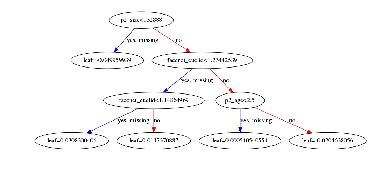

In [41]:
import matplotlib.pyplot as plt

xgb.plot_tree(xg_reg, num_trees=0)
plt.rcParams['figure.figsize'] = [100, 100]
plt.show()

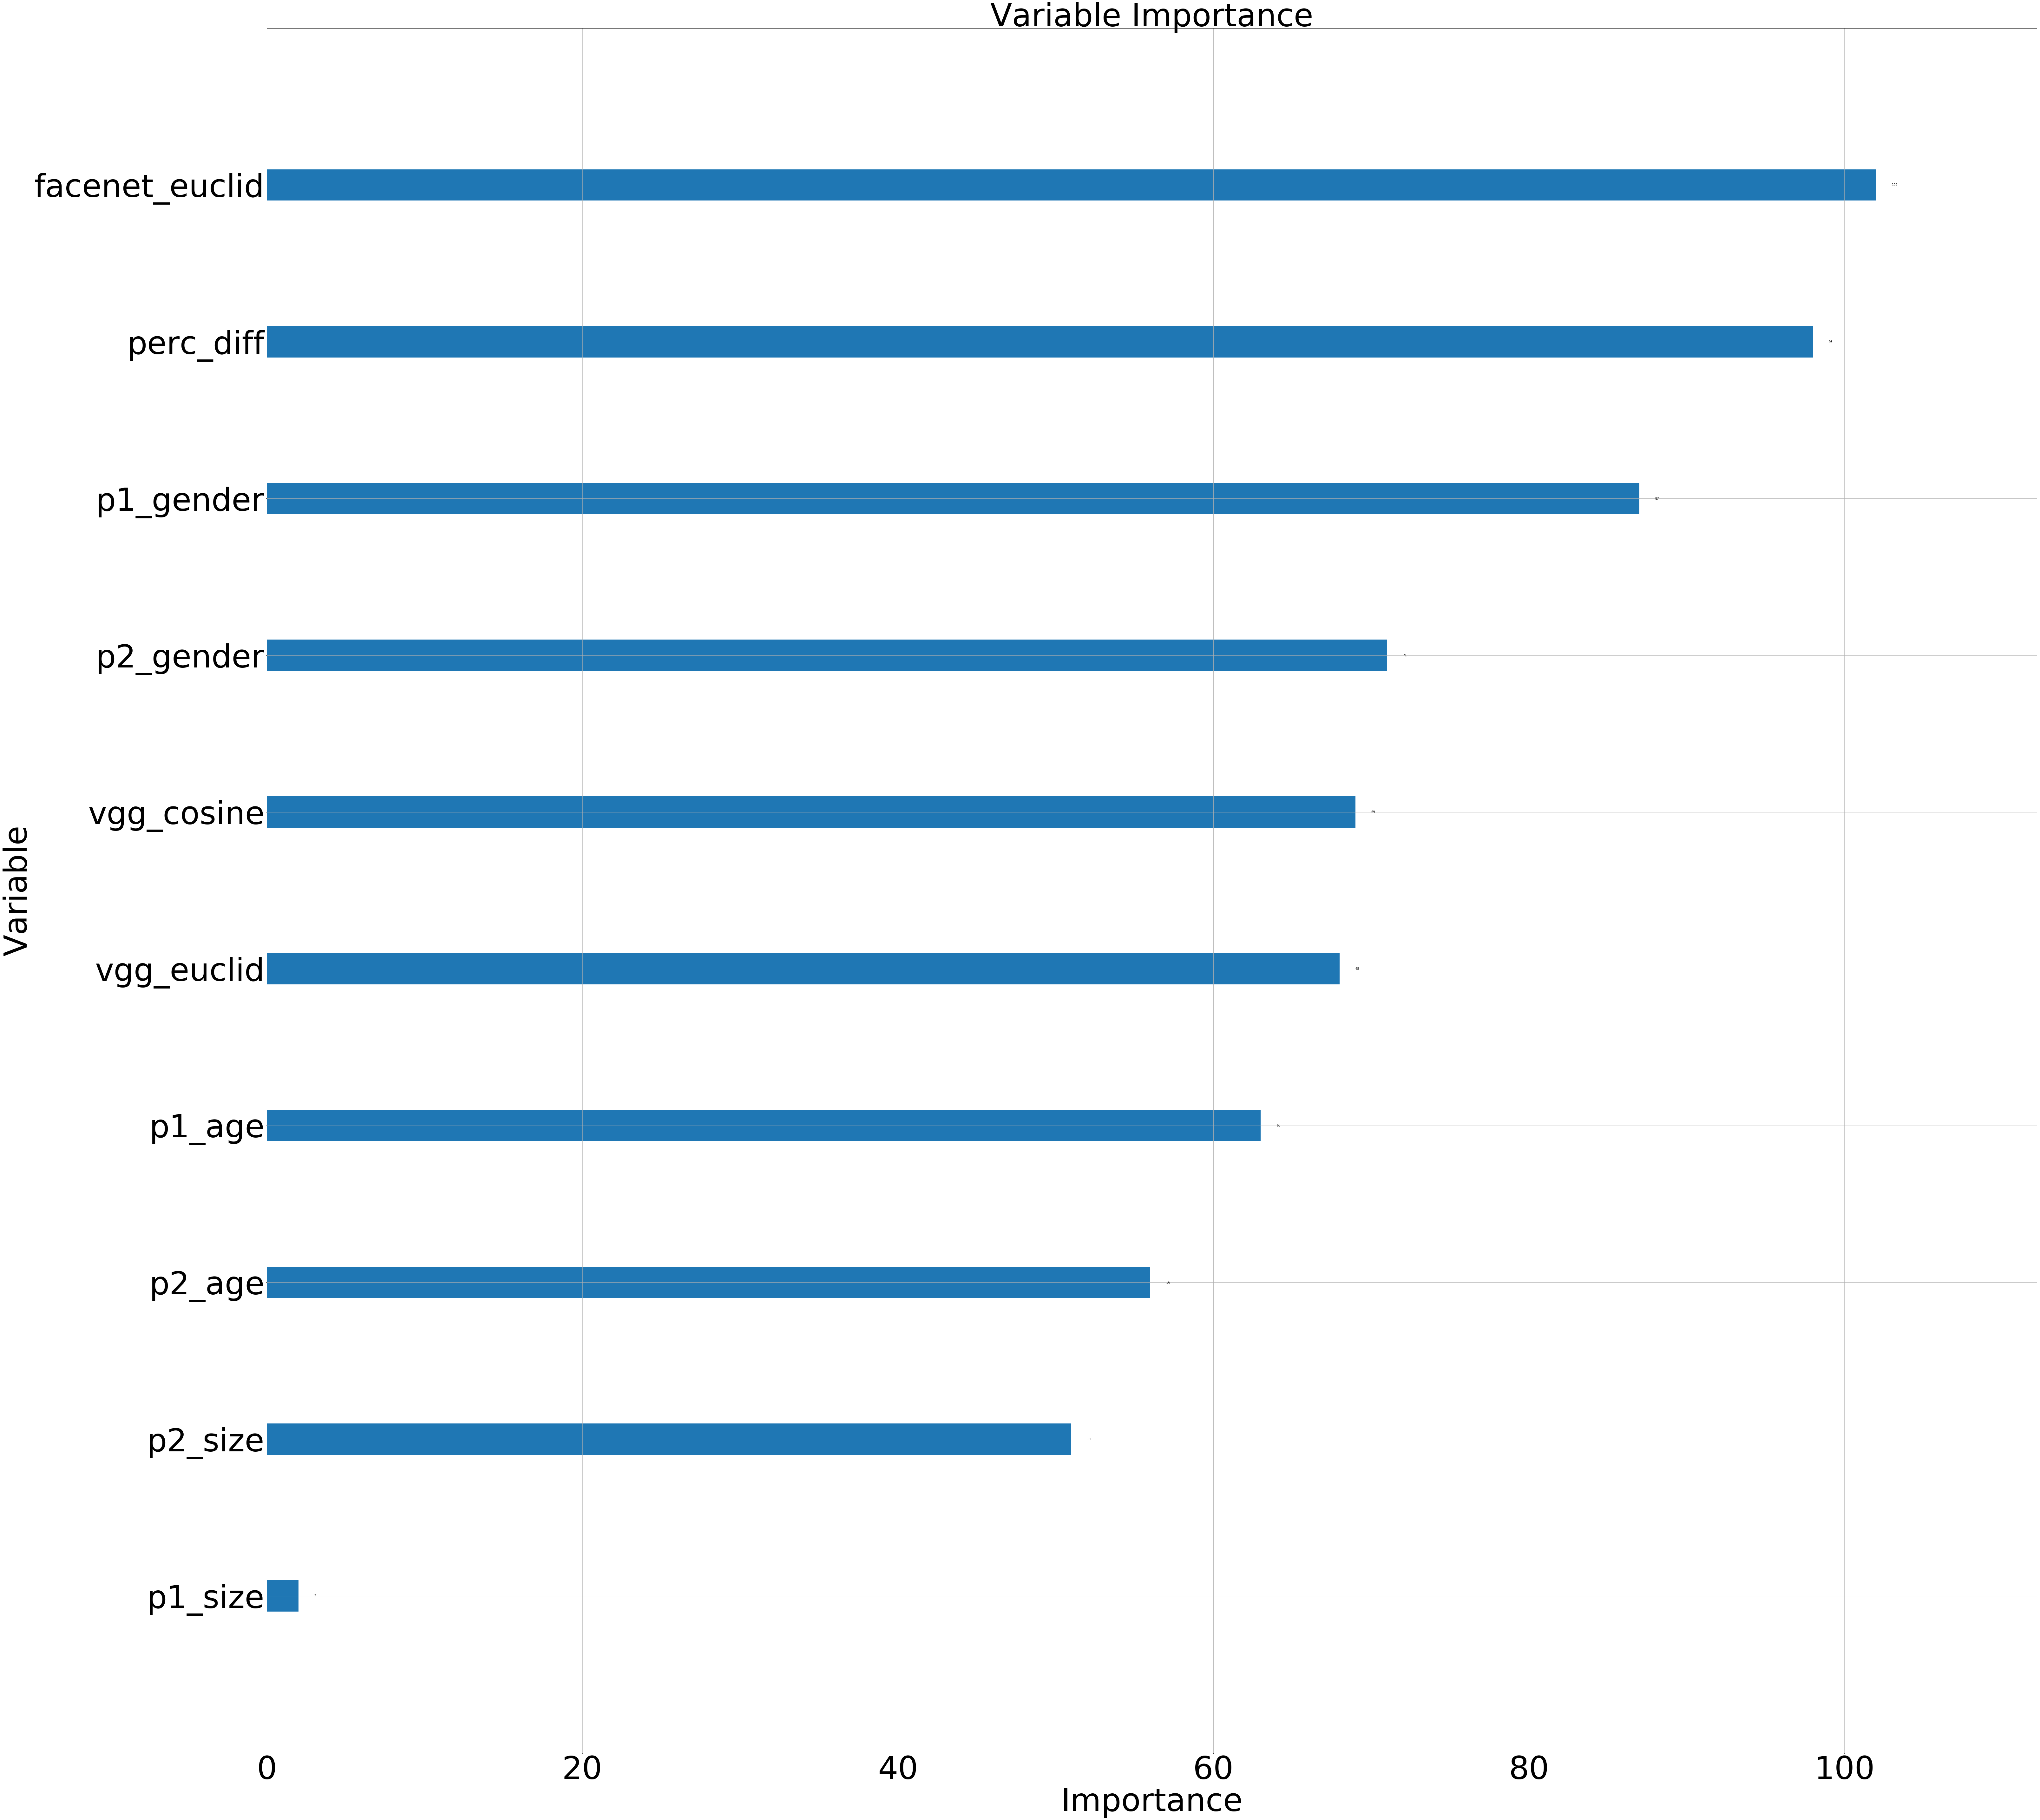

In [42]:
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [100, 100]
plt.title("Variable Importance", fontsize=100)
plt.xlabel("Importance", fontsize=100)
plt.ylabel("Variable", fontsize=100)
plt.tick_params(labelsize=100);
plt.show()

In [43]:
test_df.head(5)

,img_pair,is_related,p1_age,p2_age,p1_size,p2_size,p1_gender,p2_gender,perc_diff,vgg_cosine,vgg_euclid,facenet_euclid
0,face05508.jpg-face01210.jpg,0,5,3,150528,150528,0.001094,0.973348,0.550123,0.707243,140.457703,1.482808
1,face05750.jpg-face00898.jpg,0,5,1,150528,150528,0.271708,0.973602,0.412822,0.565814,137.597748,1.390086
2,face05820.jpg-face03938.jpg,0,6,2,150528,150528,0.020359,0.000632,0.560284,0.633922,119.730591,1.415027
3,face02104.jpg-face01172.jpg,0,5,4,150528,150528,0.999999,0.999854,0.521571,0.343631,85.147316,1.317899
4,face02428.jpg-face05611.jpg,0,7,3,150528,150528,0.999964,0.611491,0.477167,0.491167,93.863747,1.166235


**[18] PREDICTIONS**

In [44]:
submission_predictions = xg_reg.predict(final_test_df)

print(len(submission_predictions), ' final predictions')

5310  final predictions


**[19] SUBMISSION**

In [45]:
sub_df = pd.read_csv("../input/recognizing-faces-in-the-wild/sample_submission.csv")
sub_df.is_related = submission_predictions

In [46]:
sub_df.head(10)

,img_pair,is_related
0,face05508.jpg-face01210.jpg,0.308486
1,face05750.jpg-face00898.jpg,0.446066
2,face05820.jpg-face03938.jpg,0.499954
3,face02104.jpg-face01172.jpg,0.559832
4,face02428.jpg-face05611.jpg,0.810232
5,face01219.jpg-face00274.jpg,0.340860
6,face04262.jpg-face00555.jpg,0.396621
7,face03697.jpg-face01892.jpg,0.651915
8,face03524.jpg-face00319.jpg,0.699704
9,face03410.jpg-face05368.jpg,0.191270


In [47]:
sub_df.to_csv("submission.csv", index = False)

print("SUBMISSION COMPLETE!")

SUBMISSION COMPLETE!
